In [6]:
from IPython.display import Image

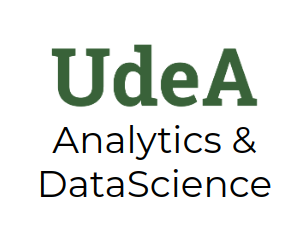

In [7]:
Image("local/imgs/udea-datascience.png")

Este notebook hace parte de los contenidos de la especialización en analítica y ciencia de datos de la UdeA

Profesor Efraín Alberto Oviendo

https://github.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/tree/master

# **MAP REDUCE EN SPARK**

# **Preparación del ambiente de trabajo**


##3. Obtener el Spark Context

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

Para Ilustrar la operación de Map Redcue vamos a utilizar tres variables


*   num: Secuencia de números del 0 al 5
*   tuplas: Pares ordenados de números en formato (clave, valor)
*   texto: Archivo de texto



In [ ]:
num = sc.parallelize([0, 1, 2, 3, 4, 5])

In [ ]:
tuplas = sc.parallelize([[0, 1], [0,2], [0,3], [1,5], [1,6], [2,9]])

In [ ]:
text = sc.textFile("local/data/animales.txt")

## **Map**

Recibe un conjunto de datos y lo transforma en un segundo conjunto de datos cuyos elementos se representan en tuplas (clave-valor)

### Función map
Devuelve un nuevo conjunto de datos distribuido formado al pasar cada elemento de la fuente a través de una función.


Usando la variable num (0, 1, 2, 3, 4, 5) apliquemos map para multiplicar cada elemento por 2

In [ ]:
num.collect()

In [ ]:
numMap=num.map(lambda x:(x,2*x))
numMap.collect()

Usando la variable text, apliquemos la función map para obtener cada uno de los elementos separados por un espacio

In [ ]:
text.collect()

In [ ]:
wordsMap = text.map(lambda line: line.split(" "))
print("El número de elementos de entrada es: ", text.count())
text.collect()
print("El número de elementos de salida es", wordsMap.count())
wordsMap.collect()


### Función flatMap
Similar al map, pero cada elemento de entrada se puede asignar a 0 o más elementos de salida. Esto significa que devuelve una secuencia en lugar de un solo elemento.


Usando la variable num (0, 1, 2, 3, 4, 5) apliquemos flatMap para multiplicar cada elemento por 2

In [ ]:
numFlatMap=num.flatMap(lambda x:(x,2*x))
numFlatMap.collect()

Usando la variable text, apliquemos la función map para obtener cada uno de los elementos separados por un espacio

In [ ]:
wordsFlatMap = text.flatMap(lambda line: line.split(" "))
print("El número de elementos de entrada es: ", text.count())
print("El número de elementos de salida es", wordsFlatMap.count())
wordsFlatMap.collect()

## **Reduce**
Utiliza como entrada las tuplas generadas por el map y genera un conjunto de datos de salida reducido a partir de la combinación de los datos recibidos

### Función reduce
Reduce los elementos de utilizando el operador binario conmutativo y asociativo especificado


Apliquemos reduce a la variable num (0, 1, 2, 3, 4, 5) para obtener la suma de los términos

In [ ]:
num.collect()

In [ ]:
numReduce=num.reduce(lambda a,b:a+b)
print("La suma es: ", numReduce)

Apliquemos reduce a la variable num (0, 1, 2, 3, 4, 5) para conseguir el valor menor

In [ ]:
numReduce=num.reduce(lambda a,b: a if a<b else b)
print("El menor es: ", numReduce)

Apliquemos reduce a la variable num (0, 1, 2, 3, 4, 5) para obtener el mayor de los términos utilizando la función max

In [ ]:
numReduce=num.reduce(lambda a,b:max(a,b))
print("El mayor es: ", numReduce)

### Función reduceByKey
Cuando se llama a un conjunto de datos de pares (K, V), devuelve un conjunto de datos de pares (K, V) donde los valores de cada clave se agregan usando la función de reducción dada, que debe ser de tipo (V, V) => V.


Visualicemos la variable tuplas

In [ ]:
tuplas.collect()

Utilicemos la variable tuplas para sumar los elementos que contengan la misma clave

In [ ]:
tuplasReduce=tuplas.reduceByKey(lambda a,b:a+b)
tuplasReduce.collect()

Utilicemos la variable tuplas para encontrar el menor valor de cada clave

In [ ]:
tuplasReduce=tuplas.reduceByKey(lambda a,b: a if a<b else b)
tuplasReduce.collect()

# **Ejemplos**

Ahora que ya sabemos que es Map Reduce y  como utilizar las funciones map y reduce, vamos a realizar algunos ejemplos 


## **Contador de Palabras**

Utilizando map reduce, vamos a contar cuantas veces se repite cada una de las palabras presentes en un texto dado.

La siguiente imagen ayudará a comprender el flujo del proceso y el papel de las funciones map y reduce

In [ ]:
Image("local/imgs/wordcount.png")

### Ingresando las palabras directamente en una variable

In [ ]:
texto = sc.parallelize(['gato', 'perro', 'conejo', 'conejo', 'gato','conejo','perro','conejo','gato'])
texto.collect()

Con la ayuda de la función map generamos la tupla (palabra,1) para cada una de las palabras ingresadas

In [ ]:
cont = texto.map(lambda x: (x,1))
cont.collect()

Con la ayuda de la función reduceByKey tomamos todas las tuplas que contengan la misma clave, en este caso la misma palabra, y sumamos sus valores, es decir las veces que aparece cada palabra

In [ ]:
res = cont.reduceByKey(lambda x, y: x + y)
print("Las siguientes tuplas nos muestran cuantas veces aparece cada palabra en el texto ingresado")
res.collect()

### Leyendo un archivo de texto


*   Leemos el archivo de texto
*   Aplicamos la función flatMap para obtener una variable con todas las palabras
*   Aplicamos la función map para genera la tupla (palabra,1)
*   Aplicamos la función reduceByKey para sumar los valores de las tuplas que contienen la misma palabra





In [ ]:
text_file = sc.textFile("local/data/animales.txt")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)
counts.collect()

Almacenamos el resultado en un fichero

In [ ]:
counts.saveAsTextFile("local/data/contAnimales")

##**Máxima Temperatura**

Vamos a leer un archivo que contiene los valores de temperatura entregados por los sensores ubicados en varias ciudades. El objetivo es encontrar cuál es la máxima temperatura reportada en cada departamento.
Fuente de los datos: www.datos.gov.co


In [ ]:
text_file = sc.textFile("local/data/temperatura.txt")
text_file.take(10)

En el archivo temperatura.txt tenemos el departamento y la temperatura separados por coma. Aplicamos un split para separar ambos valores mediante una función map

In [ ]:
data1=text_file.map(lambda a: (a.split(",")))
data1.take(10)

Usamos nuevamente una función map para generar la tupla (departamento, temperatura)

In [ ]:
data2=data1.map(lambda word: (word[0], float (word[1]) ) )
data2.take(10)

Utilizamos la función reduceByKey para encontrar el valor máximo de temperatura en cada grupo de tuplas que contengan el mismo departamento

In [ ]:
data3=data2.reduceByKey(lambda a,b: max(a,b))
print("A continuación se presenta la temperatura máxima de cada departamento")
data3.collect()